# Clustering of Social Groups Using Census Demographic Variables

#### Purpose of this notebook
- 1) Use scikit-learn K-Means to create social groups across Toronto, Vancouver, Montreal

#### Data Sources
- Census Variables: https://www12.statcan.gc.ca/census-recensement/2016/dp-pd/prof/details/download-telecharger/comp/page_dl-tc.cfm?Lang=E
- Census Geographies: https://www12.statcan.gc.ca/census-recensement/2011/geo/bound-limit/bound-limit-2016-eng.cfm

In [1]:
import pandas as pd
import geopandas as gpd
import os
import numpy as np
import matplotlib.pyplot as plt
os.chdir('C:/Users/Leonardo/OneDrive/Documents/MetroWork/RealEstateData')

In [2]:
# make dataframe with variables of interest
import re
variables = open("CensusData2016/Census/Test2Variables.txt")
var_list = []
for line in variables:
    var_list.append(line)

var_df = pd.DataFrame({'census_variable': var_list})
var_df = var_df.census_variable.str.split(pat = ".", expand=True)[[0,1]]
#var_df = var_df['1'].str.split(pat = "/n", expand=True)[[0,1]]
var_df = var_df[[0,1]]
var_df.columns = ['Member ID: Profile of Dissemination Areas (2247)', 'DIM: Profile of Dissemination Areas (2247)']

In [3]:
# Read Canada Census data by dissemination area
Canada_census_2016 = gpd.read_file('CensusData2016_MA/CanadaWide/CanadaDAs_Census2016_vars.shp')

In [4]:
#function for extracting metropolitan census blocks
def get_metrocensus(canada=None, NAMES=[]): 
    '''filters canadian census layer by metropolitan area, and dissolves all polygons. The result is metropolitan boundaries'''
    #create new col to be used with dissolve
    MAREA = canada[canada.CCSNAME.isin(NAMES)]
    return MAREA

In [5]:
# extract census blocks for all cities
CT = get_metrocensus(canada=Canada_census_2016,NAMES=['Toronto'])
CV = get_metrocensus(canada=Canada_census_2016,NAMES=['Vancouver'])
CM = get_metrocensus(canada=Canada_census_2016,NAMES=['Montréal'])
CO = get_metrocensus(canada=Canada_census_2016,NAMES=['Ottawa'])
CC = get_metrocensus(canada=Canada_census_2016,NAMES=['Calgary'])

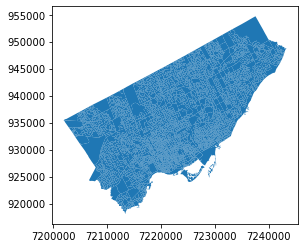

In [6]:
CT.plot()

# K-Means Clustering
### Extracting Social Groups from Census Data

### 1: Scale Data and Get rid of Outliers

In [7]:
#prepare dataframe for ML algorithm
df = pd.DataFrame(CT.iloc[:,23:214])
df = df.replace([np.inf, -np.inf], 0)
#MVDA_Census2016_vars_PCA = MVDA_Census2016_vars_PCA.drop(['index'], axis = 1)

In [8]:
#split into X data and y blocks
X = df.iloc[:,1:]  # all rows, all the features and no labels
y = df.iloc[:, 0]  # all rows, label (census blocks) only

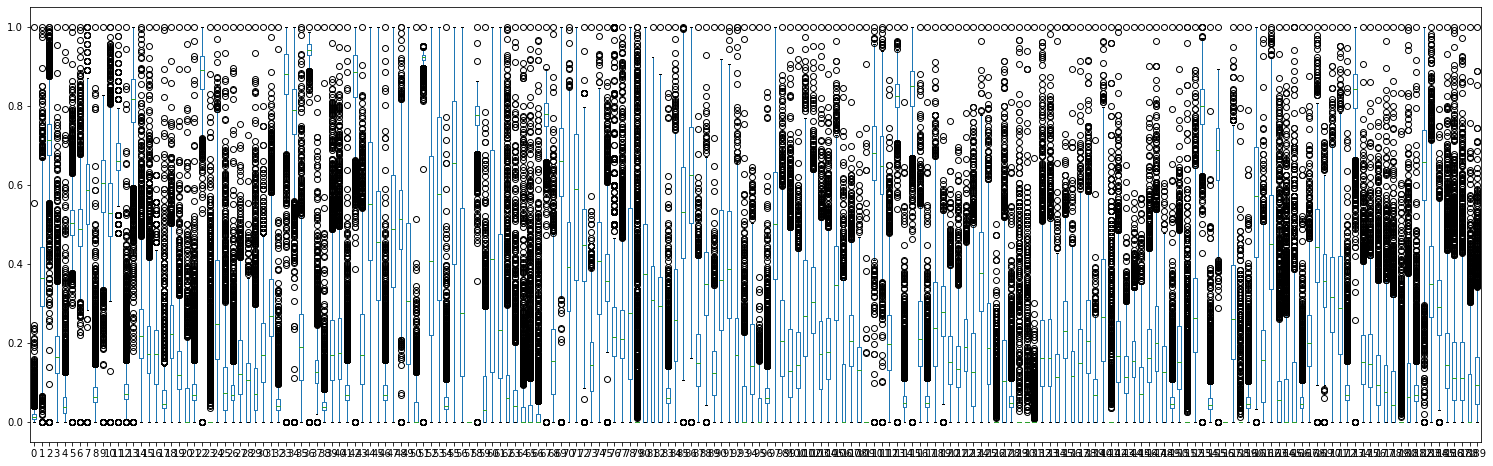

In [9]:
#import libraries, scale the data
from scipy.stats import mstats
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import (KNeighborsClassifier,
                               NeighborhoodComponentsAnalysis)
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#scaler = StandardScaler()
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
#visualize distribution of variables/outliers
pd.DataFrame(X_scaled).plot.box(figsize=(26,8))

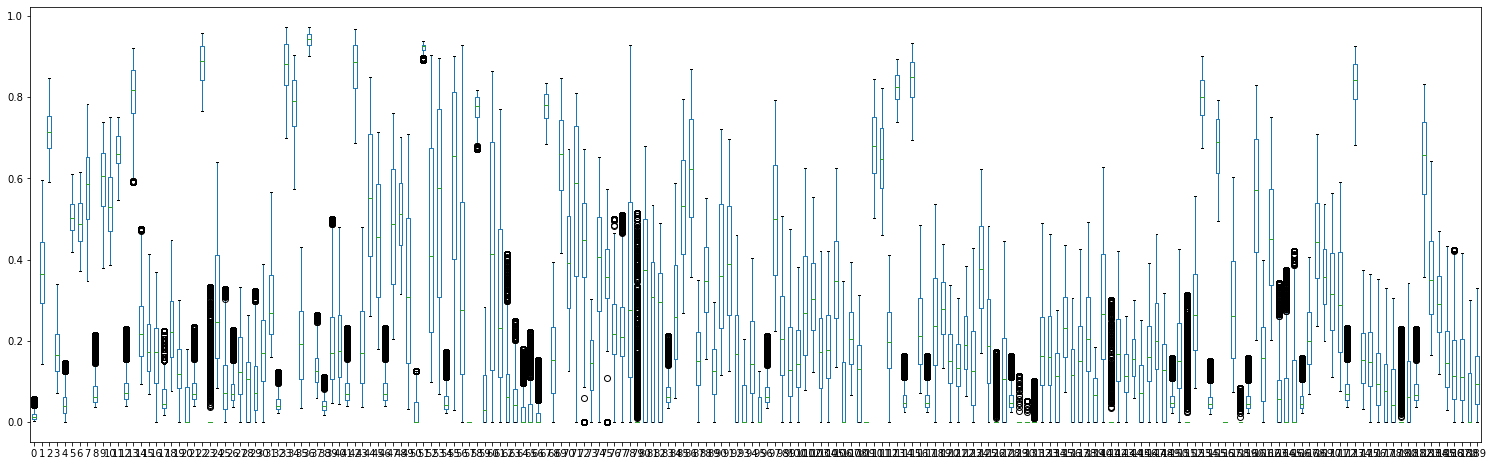

In [10]:
#remove outliers by winsorizing data
X_scaled_wd = mstats.winsorize(X_scaled, inplace = True, axis = 0, limits = [0.05, 0.05])
#visualize data
pd.DataFrame(X_scaled_wd).plot.box(figsize=(26,8))

### 2: Fit K-Means algorithm to data and find the optimal number of clusters

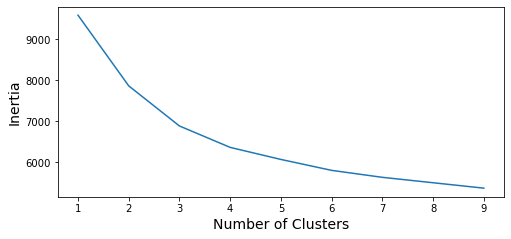

In [11]:
#import clustering algorithm data using k means
from sklearn.cluster import KMeans
from sklearn import cluster, mixture
from sklearn.metrics import silhouette_score
#to chose the right number of clusters we visualize the inertia of the clusters
kmeans_per_k = [KMeans(n_clusters=k, algorithm='auto', init='k-means++', 
                       max_iter=300, n_init=30, n_jobs=None, precompute_distances='auto',
                       random_state=5, tol=0.0001).fit(X_scaled_wd) for k in range(1, 10)]

inertias = [model.inertia_ for model in kmeans_per_k]
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias)
plt.xlabel("Number of Clusters", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.show()

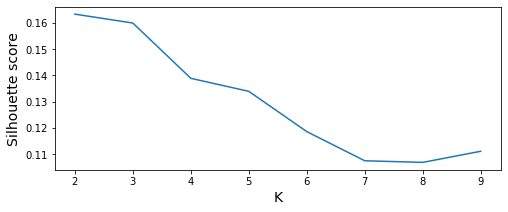

In [12]:
#we visualize the silhouette scores
silhouette_scores = [silhouette_score(X_scaled_wd, model.labels_) for model in kmeans_per_k[1:]]
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores)
plt.xlabel("K", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.show()

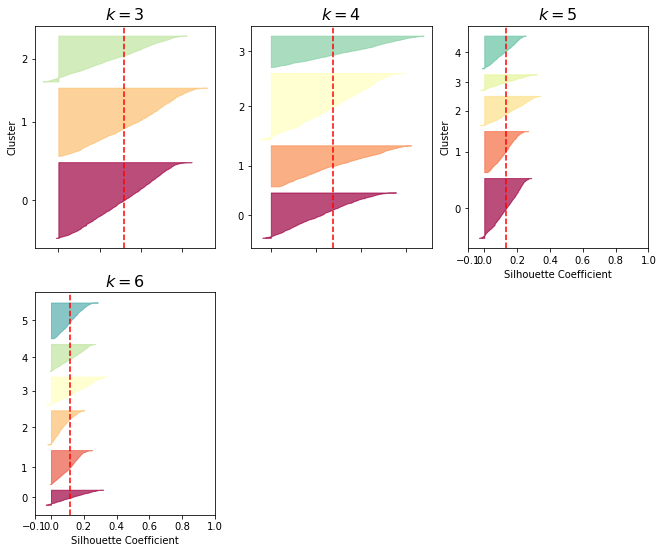

In [13]:
#the silhouette scores can be visualized for each label within each number of clusters
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter
import matplotlib

plt.figure(figsize=(11, 9))
# we visualize 4 plots, one for the result of each of k-means with 3, 4, 5, and 6 clusters 
for k in (3, 4, 5, 6):
    plt.subplot(2, 3, k - 2)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X_scaled_wd, y_pred)

    padding = len(X_scaled_wd) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = matplotlib.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

plt.show()

In [14]:
#THE CHOICE IS 4 CLUSTERS: the silhouette scores are highest, each label is about the average silhouette coefficient, and each cluster is of similar size
k4cls_rnd_10_inits_Kplus = KMeans(n_clusters=4, algorithm='auto', init='k-means++', 
                           max_iter=300, n_init=30, n_jobs=None, precompute_distances='auto',
                           random_state=5, tol=0.0001)

k4cls_Kplus = k4cls_rnd_10_inits_Kplus.fit(X_scaled_wd)

In [15]:
#now lets merge back the labels to the initial dataframe
X_std1 = pd.DataFrame(X_scaled_wd)
X_std1.columns = df.iloc[:,1:191].columns
X_std1['GEO_NAME'] = y.values
X_std1['k4cls'] = k4cls_Kplus.labels_
X_std1.head()

,6,35,36,37,38,39,40,58,59,60,...,2240,2241,2242,2243,2244,2245,2246,2247,GEO_NAME,k4cls
0,0.013284,0.357143,0.728216,0.181718,0.071429,0.520936,0.498812,0.565217,0.070328,0.547068,...,0.706422,0.299995,0.276717,0.100390,0.138705,0.145915,0.095821,0.032589,35201588,2
1,0.009853,0.405612,0.713693,0.159692,0.047619,0.507389,0.492874,0.608696,0.077696,0.621416,...,0.662069,0.345318,0.303355,0.132065,0.156402,0.197438,0.000000,0.061245,35201589,1
2,0.003145,0.313776,0.745851,0.174009,0.056277,0.530788,0.533254,0.565217,0.067649,0.646795,...,0.628571,0.369815,0.347104,0.117241,0.191985,0.212063,0.000000,0.033831,35201590,2
3,0.010988,0.390306,0.693983,0.186123,0.034632,0.518473,0.501188,0.565217,0.070328,0.600702,...,0.686869,0.330298,0.317363,0.096714,0.152715,0.224916,0.000000,0.000000,35201591,2
4,0.008214,0.311224,0.696058,0.214758,0.106061,0.544335,0.541568,0.543478,0.047555,0.618681,...,0.659341,0.336876,0.317642,0.105217,0.138451,0.174778,0.000000,0.039036,35201592,1


In [17]:
#merge back to spatial layer and save data to shapefile
CT['DAUID'] = CT['DAUID'].astype('int64')
CT_4Kcls = pd.merge(CT, X_std1, left_on='DAUID', right_on='GEO_NAME')
CC_4Kcls.to_file('CensusData2016_MA/PCA/CC_DA_Census2016_3Kcls_5.shp')

C:\Users\Leonardo\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


#### 2: Visualize the size of the clusters

Text(0.5, 1.0, 'Size of K-Means Clusters')

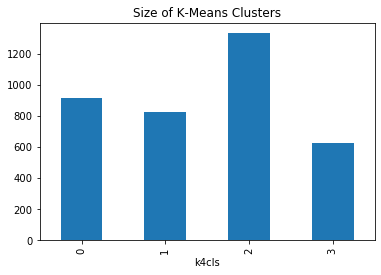

In [18]:
#visualize the size of the clusters
ksizes = X_std1.groupby('k4cls').size()
ksizes.plot(kind = 'bar')
plt.title("Size of K-Means Clusters")